# Stock prediction using RNN

In this notebook, we're going to train RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step! In this project, Tesla stock prices data are used for our model prediction.
<img src='assets/time_prediction.png' width=40% />

**The project outline is as follows:** 
1. Create our asset prices data
2. Define an RNN in PyTorch
3. Train our network and test the prediction against actual asset prices

### Import resources and create data 

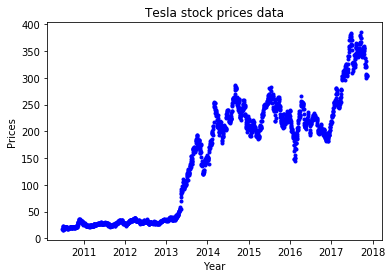

In [340]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 

data = []

# retrieve tesla stock prices from our txt file to dataframe
df = pd.read_csv('data/Stocks/tsla.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
data.append(df)

# close prices as y 
y = df['Close'] 

# display the data from 2011 to 2018
plt.plot(df['Date'], y, 'b.')
plt.title("Tesla stock prices data")
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

---
## Define the RNN

To define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Read the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) for better understanding of recurrent layers.

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps to see how it performs.

In [345]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=128
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem that we try to train an RNN to accurately predict the next data point, given a current data point. So to calculate the regression loss,  we use the mean squared error. Additionally, we use Adam optimizer for the recurrent model learning steps.  


In [346]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions as the training progresses. 

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [347]:
# train the rnn
def stock_train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    
    for batch_i, step in enumerate(range(n_steps)):
      
        df = pd.read_csv('data/Stocks/tsla.us.txt')
        
        # first 80% of data is used for training, the remaining data for testing
        train_data = np.round(len(df)*0.8)
        df = df[0:int(train_data)]
        
        # convert dataframe date to real date for x axis  
        df['Date'] = pd.to_datetime(df['Date'])
        
        # asset close prices for y axis
        data = np.array(df['Close'])
     
        data.resize((len(df['Date']),1))
        
        x = data[:-7] # all but the last 7-day close prices of data
        y = data[7:] # all but the first 7-day close prices of data 
        
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)
        
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        
        # zero gradients
        optimizer.zero_grad()
        
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(df['Date'][7:], x, 'r.') # input
            plt.plot(df['Date'][7:], prediction.data.numpy(), 'b.') # training output predictions
            plt.title("Tesla stock prices training output ")
            plt.xlabel("Year")
            plt.ylabel("Prices")
            plt.legend(['input, x', 'training output, y'])
            plt.show()
    
    return rnn


Loss:  23518.30078125


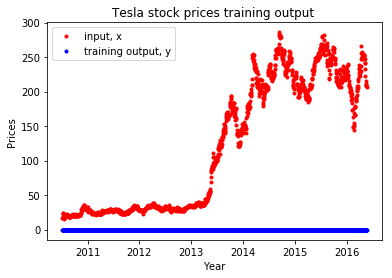

Loss:  9290.267578125


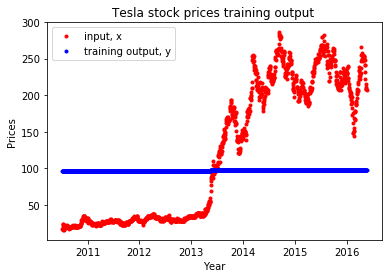

Loss:  5565.46435546875


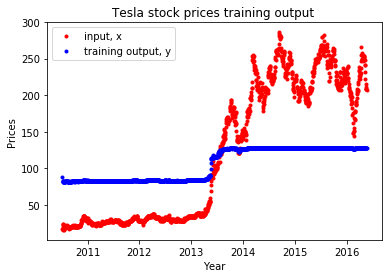

Loss:  700.91845703125


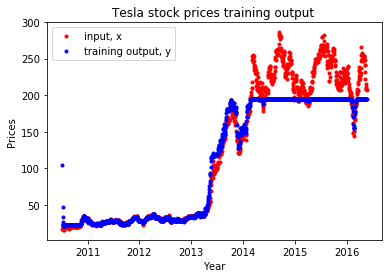

Loss:  246.82293701171875


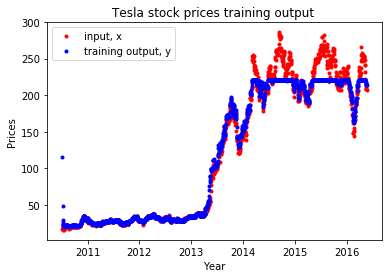

Loss:  164.9405059814453


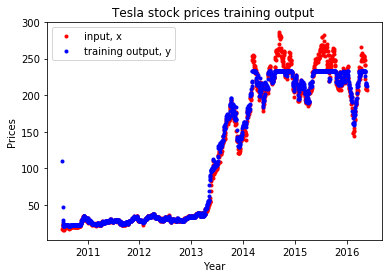

Loss:  141.00689697265625


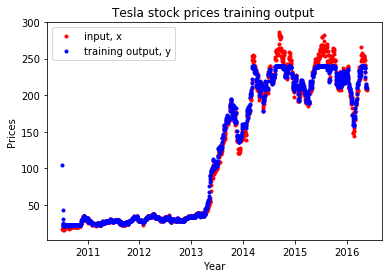

Loss:  135.03378295898438


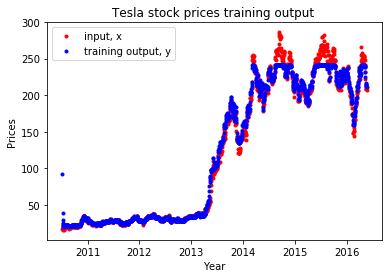

Loss:  125.49956512451172


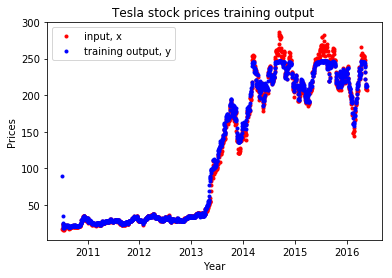

Loss:  124.56202697753906


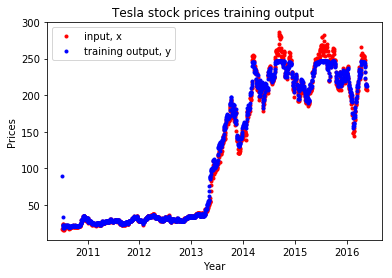

Loss:  127.8471908569336


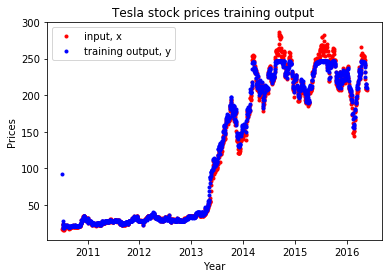

Loss:  121.6534194946289


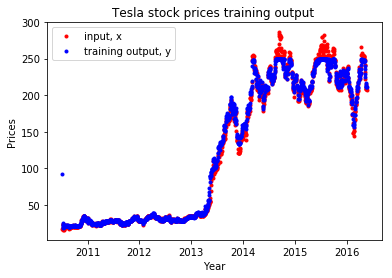

Loss:  118.72286987304688


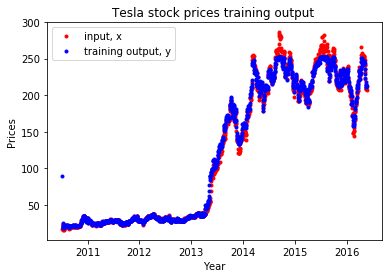

Loss:  126.46676635742188


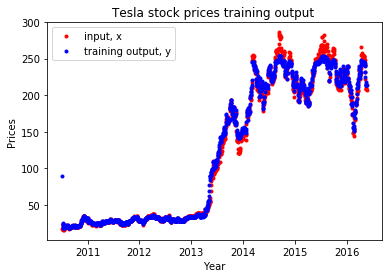

Loss:  121.2347640991211


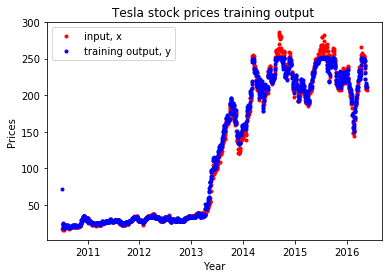

Loss:  120.62023162841797


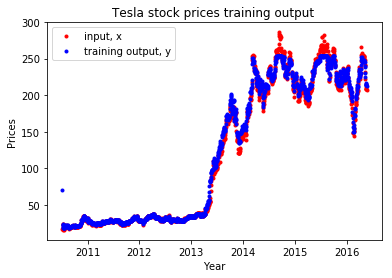

Loss:  122.05220794677734


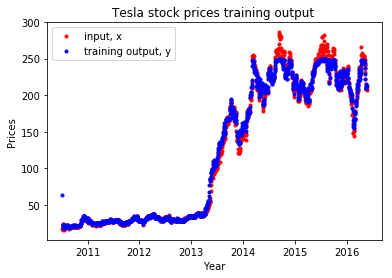

Loss:  116.8737564086914


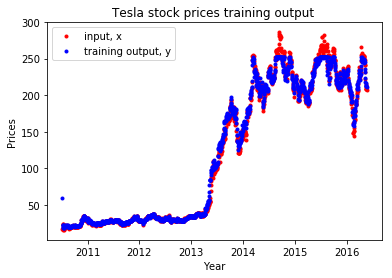

Loss:  132.09730529785156


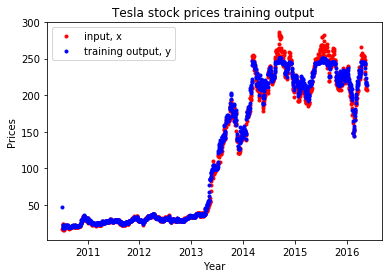

Loss:  118.89696502685547


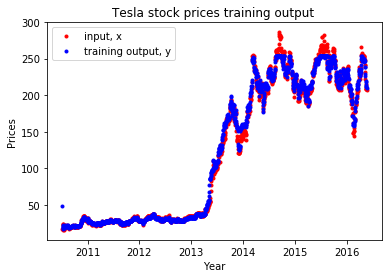

In [348]:
# train the rnn and monitor results
n_steps = 2000
print_every = 100

trained_rnn = stock_train(rnn, n_steps, print_every)

In [363]:
def test(rnn):
    
    hidden = None
    df = pd.read_csv('data/Stocks/tsla.us.txt')
    
    # get the first 230 day close prices test data into dataframe, note that this data has not been seen by the model
    test_data = np.round(len(df)*0.8)
    df = df[int(test_data):int(test_data)+230]
    
    # convert dataframe date column into actual date as x-axis 
    df['Date'] = pd.to_datetime(df['Date'])
    
    # close prices data as y-axis 
    data = np.array(df['Close'])
     
    data.resize((len(df['Date']),1))
        
    x = data[:-7] # all but the last 7-day close prices of data
    y = data[7:]  # all but the first 7-day close prices of data  
        
        
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)
    
    # outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)
    
    # calculate the loss
    loss = criterion(prediction, y_tensor)
    
    print('Loss: ', loss.item())
    plt.figure(figsize=(15,10))
    
    plt.plot(df['Date'][7:], y, 'r.') # actual asset prices
    plt.plot(df['Date'][7:], prediction.data.numpy(), 'b.') # predictions
    plt.legend(['Actual', 'prediction'])
    plt.title("Tesla stock prediction using RNN")
    plt.xlabel("Date")
    plt.ylabel("Prices")
    
    plt.show()
    
    #print(df['Date'][0:7][0:7])
    

Loss:  315.0397644042969


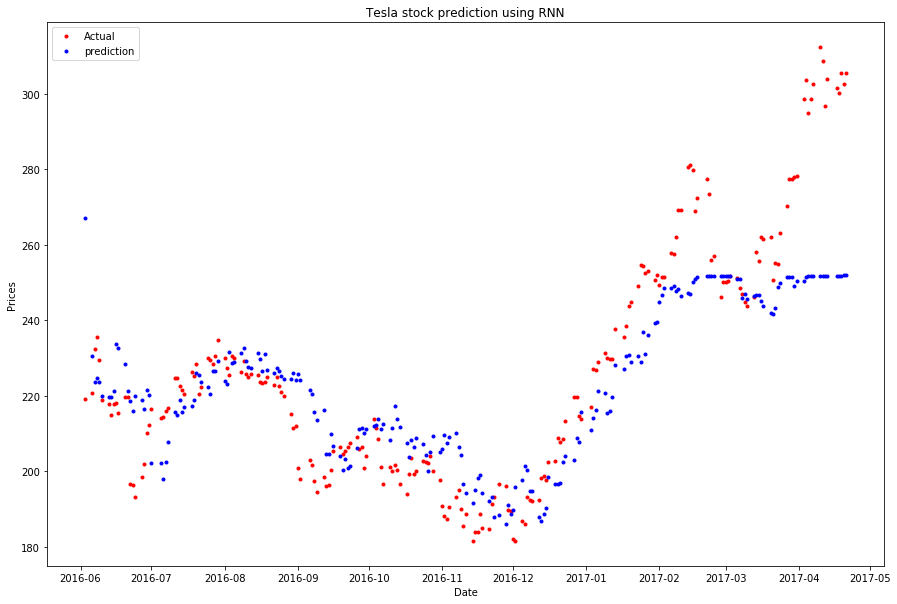

In [364]:
test_rnn = test(rnn)

**Evaluation:**
In the RNN training results above, the final RNN model training output recorded a loss of 118, which is a great improvement from its initial loss of 23518. This tremendous improvement in training was due to the use of 7 days lag asset prices in training the model, however when a larger lag, for instance > 90 days lag prices was used for training, the final loss is around 400, which is a bad training result.    

When testing the model with unseen data, the loss is 315, and from observation of the predicted output versus actual prices, the RNN does not seem to predict accurately during the consolidation period from 2016-06 till 2016-12, and when aset prices make all time highs from 2017-02 till 2017-05, the model was not able to predict further because it hasnt seen those prices in the training set previously (traning set high:260; low:20), hence a flat prices prediction is seen from 2017-02 till 2017-05. 

The model is only suitable to predict asset prices in the consolidation period (eg. asset prices are not expected to make new high or new low of its training data set). The model faces gradient descent vanishing problem, and it only stores very short term memory for prediction, this can be a problem in predicting highly volatile asset prices. Next project, we will implement a LSTM model for more accurate asset prices prediction.





